# Model predictions over threshold range
Used for model predictions in fig 4

In [11]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# unchanged from example

import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False  # no path exists between the nodes


def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m=[]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network
    
    m.append(measure(g, beliefs, 0, 0)[0])  # measure only final state

    return pd.DataFrame(m)  # format as pandas DataFrame


# changes made here remove some of the measurements that are not needed for the sensitivity analysis
# and also vary the thresholds used over the full range, returning the result.

def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    # correlation between a belief and it's most popular neighbor
    adopt_counts = pd.DataFrame()
    adopt_counts['self'] = adopt.sum(axis=0)
    

    # clustering coefficient of n% most popular beliefs
    # shuffle within sorted value so that when 10% falls within a level of popularity
    # we don't add spurious clustering by selecting sequential beliefs
    adopt_counts['shuffle'] = np.random.rand(len(adopt_counts))
    adopt_counts.sort_values(by=['self', 'shuffle'], inplace=True, ascending=False)
    cluster_list = []
    for percent in np.arange(0.01,1,.01):
        leaders = adopt_counts.iloc[:int(len(adopt_counts) * percent)]  # take leading percent of beliefs
        popular_graph = nx.from_edgelist(list(leaders.index))  # construct semantic network from leading beliefs
        cluster_list.append(nx.average_clustering(popular_graph))
    res['popular belief clustering'] = np.array(cluster_list)

    # similarity btw 5% and 95% most similar pairs
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    
    res['percentiles similarity'] = np.percentile(corrs, np.arange(1,100,1))

    # PC1 percent variance
    pca = PCA(n_components=10)
    pca.fit(adopt)
    res['PC percent of variance'] = np.array(pca.explained_variance_ratio_)
    
    #shuffled for 'expectation' analysis
    shuffle_adopt = pd.DataFrame(index=adopt.index, columns=adopt.columns)
    for col in shuffle_adopt.columns:
        shuffle_adopt[col] = np.random.permutation(adopt[col].values)
    
    print(shuffle_adopt)
    adopt = shuffle_adopt
    adopt_counts = pd.DataFrame()
    adopt_counts['self'] = shuffle_adopt.sum(axis=0)
    

    # clustering coefficient of n% most popular beliefs
    # shuffle within sorted value so that when 10% falls within a level of popularity
    # we don't add spurious clustering by selecting sequential beliefs
    adopt_counts['shuffle'] = np.random.rand(len(adopt_counts))
    adopt_counts.sort_values(by=['self', 'shuffle'], inplace=True, ascending=False)
    cluster_list = []
    for percent in np.arange(0.01,1,.01):
        leaders = adopt_counts.iloc[:int(len(adopt_counts) * percent)]  # take leading percent of beliefs
        popular_graph = nx.from_edgelist(list(leaders.index))  # construct semantic network from leading beliefs
        cluster_list.append(nx.average_clustering(popular_graph))
    res['shuffle popular belief clustering'] = np.array(cluster_list)

    # similarity btw 5% and 95% most similar pairs
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    
    res['shuffle percentiles similarity'] = np.percentile(corrs, np.arange(1,100,1))

    # PC1 percent variance
    pca = PCA(n_components=10)
    pca.fit(adopt)
    res['shuffle PC percent of variance'] = np.array(pca.explained_variance_ratio_)
    

    return res, initial_susceptible, initial_adopted


def run(n_agents=60, deg=3, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------
    # create a random connected social network g0
    connected = False
    while not connected:
        g0 = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
        connected = nx.is_connected(g0)

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Interdependent simulation
    # -------------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Independent simulation
    # ----------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions

    # calculate the population likelihood of being susceptible to a given (non-held) belief
    p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
         (1 - res1.loc[0, '% adopted']))

    # choose a set of beliefs for each agent to be susceptible to
    new_sus = {}
    for agent in g2:
        gc = nx.complete_graph(n_concepts)  # potentially susceptible to any belief
        gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
        # from remainder, randomly select a subset of beliefs to be susceptible to
        edges = list(itertools.compress(
            list(gc.edges()),  # selection candidates
            np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
        ))
        edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
        new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

    nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame




In [7]:
n_sims = 1000
res = []
for i in range(n_sims):
    try:
        res.append(run())
        print('.', end='')
    except KeyboardInterrupt:
        raise
    except:
        print('!', end='')

    


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
df = pd.concat(res)
df

,% susceptible (inter),% adopted (inter),popular belief clustering (inter),percentiles similarity (inter),PC percent of variance (inter),shuffle popular belief clustering (inter),shuffle percentiles similarity (inter),shuffle PC percent of variance (inter),% susceptible (indep),% adopted (indep),popular belief clustering (indep),percentiles similarity (indep),PC percent of variance (indep),shuffle popular belief clustering (indep),shuffle percentiles similarity (indep),shuffle PC percent of variance (indep)
0,0.694556,0.612500,"[0.0, 0.0, 0.3925925925925926, 0.2472222222222...","[-0.2386193252959969, -0.21828502746837042, -0...","[0.10621363796485316, 0.08976875941553633, 0.0...","[0.0, 0.0, 0.0, 0.10555555555555556, 0.2527777...","[-0.10527146806831186, -0.09011235966188738, -...","[0.03530815531384824, 0.03277158909410014, 0.0...",0.279500,0.156222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.11577506914153801, -0.10319818798159336, -...","[0.04925422116063685, 0.04356353314599327, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.104593937942034, -0.09214406136195842, -0....","[0.03579025562125175, 0.03420161140069002, 0.0..."
0,0.668283,0.580100,"[0.0, 0.0, 0.3619047619047619, 0.525, 0.611111...","[-0.22668650708307334, -0.20438558117603042, -...","[0.13455034207756197, 0.08302192336196532, 0.0...","[0.0, 0.0, 0.3619047619047619, 0.6583333333333...","[-0.08525948148492032, -0.06870976161778375, -...","[0.03382485300457382, 0.033200675125894426, 0....",0.273969,0.151561,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1166666666666...","[-0.12345585169442957, -0.11194572795727967, -...","[0.04734752030840026, 0.04580523212787458, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334,...","[-0.11379198518706996, -0.09696761260619476, -...","[0.035306030867474206, 0.033609114481056884, 0..."
0,0.670903,0.567001,"[0.0, 0.4333333333333334, 0.3619047619047619, ...","[-0.24423461317537154, -0.23270748404534525, -...","[0.10798047413943969, 0.07659544976709555, 0.0...","[0.0, 0.4333333333333334, 0.31428571428571433,...","[-0.10732486454476828, -0.0953430277878321, -0...","[0.034089371299143585, 0.03230699633239088, 0....",0.304515,0.171070,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07936507...","[-0.10435646543931254, -0.09480928423881693, -...","[0.05125212251666067, 0.042909657835318804, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07936507...","[-0.09650637131946946, -0.08620445508649818, -...","[0.0346369290524253, 0.03293942240234028, 0.03..."
0,0.649383,0.556173,"[0.0, 0.0, 0.175, 0.3404761904761905, 0.203373...","[-0.2256974790075984, -0.2097118231380681, -0....","[0.09904583959875533, 0.07582473199478948, 0.0...","[0.0, 0.0, 0.0, 0.31168831168831174, 0.2371794...","[-0.10405832844379649, -0.0922401155732708, -0...","[0.03381576397089024, 0.03297011643192354, 0.0...",0.276150,0.152974,"[0.0, 0.0, 0.1515151515151515, 0.1282051282051...","[-0.12533164736251778, -0.11394892085391894, -...","[0.04908608925336413, 0.04716099335929587, 0.0...","[0.0, 0.0, 0.1515151515151515, 0.1282051282051...","[-0.10470575796711673, -0.08999482725730477, -...","[0.0358478653735822, 0.034173768119653954, 0.0..."
0,0.685452,0.602564,"[0.0, 0.0, 0.39999999999999997, 0.482142857142...","[-0.20287088102297682, -0.1823005107930111, -0...","[0.11319582012570428, 0.07112931664471335, 0.0...","[0.0, 0.0, 0.0, 0.48214285714285715, 0.4317460...","[-0.09061265259867776, -0.08011304672123308, -...","[0.03311275756440026, 0.031772809273876344, 0....",0.274415,0.155295,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.1120678571715393, -0.10179038146672278, -0...","[0.04873435995059725, 0.043912287639852526, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10160829478895794, -0.09268894831523378, -...","[0.036337237413202016, 0.03332948844547339, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.685354,0.602189,"[0.0, 0.4333333333333334, 0.5476190476190476, ...","[-0.22142716796244064, -0.2015703487

In [35]:
df.to_pickle('threshold_sensitivities_shuffle.pickle')

In [36]:
df = pd.read_pickle('threshold_sensitivities_shuffle.pickle')

In [14]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.figsize": (4, 3),
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 8,
    
    "lines.linewidth": 2,
    "lines.marker": "",
    "lines.markersize": 8,
    
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": "grey",
    "axes.labelsize": 8,
    "axes.labelcolor": "grey",
    "axes.facecolor": "#00000000",
    
    "xtick.color": "grey",
    "xtick.labelsize": 8,
    "xtick.major.size": 2,
    
    "ytick.major.size": 0,
    "ytick.color": "grey",
    "ytick.labelsize": 8,
    
    "text.color": "grey",
    "text.usetex": False
})


In [32]:
collector = []
for i, row in df['popular belief clustering (inter)'].items():
    collector.append(row)
    
inter_clustering = pd.DataFrame(collector, columns=range(1,100,1)).mean()


collector = []
for i, row in df['shuffle popular belief clustering (inter)'].items():
    collector.append(row)
shuffle_inter_clustering = pd.DataFrame(collector, columns=range(1,100,1)).mean()


collector = []
for i, row in df['popular belief clustering (indep)'].items():
    collector.append(row)    
indep_clustering = pd.DataFrame(collector, columns=range(1,100,1)).mean()


collector = []
for i, row in df['shuffle popular belief clustering (indep)'].items():
    collector.append(row)
    
shuffle_indep_clustering = pd.DataFrame(collector, columns=range(1,100,1)).mean()


pd.to_pickle([inter_clustering, indep_clustering],
             "simulated_clustering_shuffle_all.pickle")

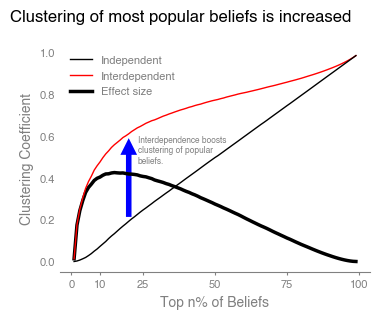

In [34]:
collector = []
for i, row in df['popular belief clustering (inter)'].items():
    collector.append(row)
    
inter_df = pd.DataFrame(collector, columns=range(1,100,1))
inter_clustering = inter_df.mean()

collector = []
for i, row in df['popular belief clustering (indep)'].items():
    collector.append(row)
    
indep_df = pd.DataFrame(collector, columns=range(1,100,1))
indep_clustering = indep_df.mean()
effect = (inter_df - indep_df).mean()


plt.plot(indep_clustering, 'k', label="Independent", alpha=1, linewidth=1, zorder=10)
plt.plot(inter_clustering, 'r', label="Interdependent", alpha=1, linewidth=1, zorder=9)
plt.plot(effect, 'k', label="Effect size", alpha=1, linewidth=2.5, zorder=8)



plt.gca().annotate("", xy=(20, inter_clustering[20]),  xycoords='data',
            xytext=(20, indep_clustering[20]), textcoords='data',
            arrowprops=dict(facecolor='b', shrink=0.05, linewidth=0),
            horizontalalignment='right', verticalalignment='top',
            )
plt.figtext(x=.32, y=.58, s='Interdependence boosts\nclustering of popular\nbeliefs.', 
            va='top', ha='left', size=6)


plt.xlabel("Top n% of Beliefs", fontsize=10)
plt.ylabel("Clustering Coefficient", fontsize=10)
plt.xticks([0, 10, 25, 50, 75, 100])
plt.legend(frameon=False, loc='upper left')
plt.suptitle('Clustering of most popular beliefs is increased', 
             x=0, y=1, ha='left', va='top', fontsize=12, color='k');

In [30]:
collector = []
for i, row in df['percentiles similarity (inter)'].items():
    collector.append(row)
inter_similarity = pd.DataFrame(collector, columns=range(1,100,1)).mean()

collector = []
for i, row in df['percentiles similarity (indep)'].items():
    collector.append(row)
indep_similarity = pd.DataFrame(collector, columns=range(1,100,1)).mean()


collector = []
for i, row in df['shuffle percentiles similarity (inter)'].items():
    collector.append(row)
shuffle_inter_similarity = pd.DataFrame(collector, columns=range(1,100,1)).mean()

collector = []
for i, row in df['shuffle percentiles similarity (indep)'].items():
    collector.append(row)
shuffle_indep_similarity = pd.DataFrame(collector, columns=range(1,100,1)).mean()


pd.to_pickle([inter_similarity, indep_similarity],
            "simulated_similarity.pickle")

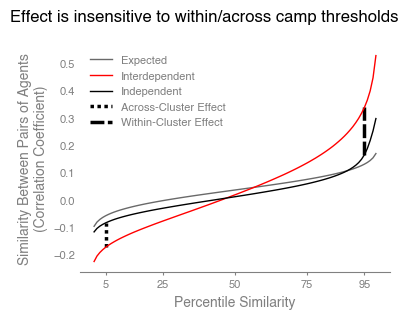

In [31]:
plt.plot(shuffle_inter_similarity, 'dimgrey', label="Expected", alpha=1, linewidth=1)
plt.plot(inter_similarity, 'r', label="Interdependent", alpha=1, linewidth=1)
plt.plot(indep_similarity, 'k', label="Independent", alpha=1, linewidth=1)

plt.vlines(5, inter_similarity.loc[5], indep_similarity.loc[5], 'k', linestyles=(0,(1,1)), linewidth=2.5, label="Across-Cluster Effect")
plt.vlines(95, indep_similarity.loc[95], inter_similarity.loc[95], 'k', linestyles=(0,(4,1)), linewidth=2.5, label="Within-Cluster Effect")

plt.xlabel("Percentile Similarity", fontsize=10)
plt.ylabel("Similarity Between Pairs of Agents\n(Correlation Coefficient)", fontsize=10)
plt.xticks([5, 25, 50, 75, 95])
plt.legend(frameon=False)
plt.suptitle('Effect is insensitive to within/across camp thresholds', 
             x=-.05, y=1, ha='left', va='top', fontsize=12, color='k');
plt.savefig("insensitive_to_camp_thresholds.png", dpi=200, bbox_inches='tight')

In [23]:
collector = []
for i, row in df['PC percent of variance (inter)'].items():
    collector.append(row)
inter_pc = pd.DataFrame(collector, columns=range(1,11,1)).mean()



collector = []
for i, row in df['shuffle PC percent of variance (inter)'].items():
    collector.append(row)
    
shuffle_inter_pc = pd.DataFrame(collector, columns=range(1,11,1)).mean()


collector = []
for i, row in df['PC percent of variance (indep)'].items():
    collector.append(row)
indep_pc = pd.DataFrame(collector, columns=range(1,11,1)).mean()



collector = []
for i, row in df['shuffle PC percent of variance (indep)'].items():
    collector.append(row)
    
shuffle_indep_pc = pd.DataFrame(collector, columns=range(1,11,1)).mean()



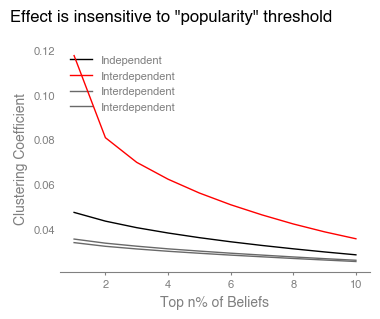

In [27]:
plt.plot(indep_pc, 'k', label="Independent", alpha=1, linewidth=1, zorder=10)
plt.plot(inter_pc, 'r', label="Interdependent", alpha=1, linewidth=1, zorder=9)
plt.plot(shuffle_inter_pc, 'dimgrey', label="Interdependent", alpha=1, linewidth=1, zorder=9)
plt.plot(shuffle_indep_pc, 'dimgrey', label="Interdependent", alpha=1, linewidth=1, zorder=9)


plt.xlabel("Top n% of Beliefs", fontsize=10)
plt.ylabel("Clustering Coefficient", fontsize=10)
plt.legend(frameon=False, loc='upper left')
plt.suptitle('Effect is insensitive to "popularity" threshold', 
             x=0, y=1, ha='left', va='top', fontsize=12, color='k');

In [34]:
pd.to_pickle([inter_pc, indep_pc],
             "simulated_pc.pickle")